# What is the True Normal Human Body Temperature? 

### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

In this exercise, I will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from numpy.random import seed
from numpy.random import randn
from statsmodels.graphics.gofplots import qqplot

sns.set()
% matplotlib inline

In [2]:
# import dataset
df = pd.read_csv('data/human_body_temperature.csv')

In [3]:
df.head()

,temperature,gender,heart_rate
0,99.3,F,68.0
1,98.4,F,81.0
2,97.8,M,73.0
3,99.2,F,66.0
4,98.0,F,73.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 3 columns):
temperature    130 non-null float64
gender         130 non-null object
heart_rate     130 non-null float64
dtypes: float64(2), object(1)
memory usage: 3.1+ KB


## Q1. Is the distribution of body temperatures normal?

In [5]:
df.temperature.describe()

count    130.000000
mean      98.249231
std        0.733183
min       96.300000
25%       97.800000
50%       98.300000
75%       98.700000
max      100.800000
Name: temperature, dtype: float64

The sample mean is 98.2 degrees Fahrenheit - since this is very close to the population mean, we have reason to believe that temperature is normally distributed. However, we should look into this more. We can begin to see if body temperature is normally distributed by plotting a histogram of the temperatures:

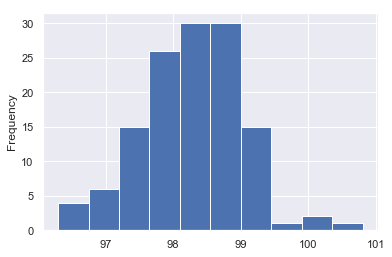

In [6]:
df.temperature.plot(kind='hist')

The histogram appears roughly bell-shaped, but the right half of the plot drops to a level low enough to explore this question further.

We can also graphically test for normality with a Quantile-Quantile plot, which will plot a standardized version of the sample data on the y-axis against its corresponding point in the normal distribution on the x-axis. If the sample data is normally distributed, the plot will look like a straight line at a 45 degree angle, signifying a strong positive correlation. Any deviation from this line indicates signs of a non-normal distribution. (Information sourced from [Wikipedia](https://en.wikipedia.org/wiki/Normality_test) and [Machine Learning Mastery](https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/)).

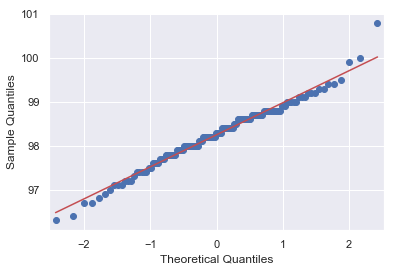

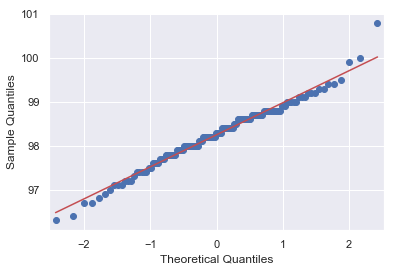

In [7]:
# q-q plot
qqplot(df.temperature, line='s')

The plot of the samples aligns with the normal distribution remarkably well until we get to the tails of the distribution, which stray a bit. However, since this sample is relatively small at 130 data points (compared to the entire human population of over 7 billion), I will say that this distribution is normal, and that the normal distribution would become more apparent as the sample size increased.

However, let's do one more check. Another way to test for a normal distribution is by calculating the z-scores of the sample maximum and minimum. According to the Wikipedia article for normality tests:
>...if one has a 3σ event (properly, a 3s event) and substantially fewer than 300 samples, or a 4s event and substantially fewer than 15,000 samples, then a normal distribution will understate the maximum magnitude of deviations in the sample data.

In [8]:
z = st.zscore(df.temperature.sort_values())
print('Min z-score:',z.min())
print('Max z-score:', z.max())

Min z-score: -2.6688711006174164
Max z-score: 3.4924927267747687


The z-score for the maximum is above 3, which would lead us to believe that the normal distribution may not be the best distribution to describe the data. From our previous graphical analysis, however, we know that the tails of the distribution stray much more from the normal distribution than the rest of the data. Therefore, it's reasonable to believe that this single z-score can't justify ruling out a normal distribution to describe temperature data.

## Q2. Is the sample size large? Are the observations independent?

Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.

Since we do not know whether this same was taken with replacement, another way we can test for an independent distribution is by using the 10% rule. The 10% rule states that if a sample size is less than 10% if the size of the total population, than the observations in the sample can be assumed to be independent.

Our sample size is 130, as we saw when running the **describe** function on the temperature data. Therefore, we can assume that the observations are independent.

## Q3. Is the true population mean really 98.6 degrees F?
   
- First, try a bootstrap hypothesis test.
- Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
- In this situation, is it appropriate to use the $t$ or $z$ statistic? 
- Now try using the other test. How is the result different? Why?


Hypotheses:

If X = body temperature of the human population,

H<sub>0</sub>: $u$<sub>X</sub> = 98.6  
H<sub>a</sub>: $u$<sub>X</sub> $\neq$$ 98.6

### Bootstrap Approacch

In [9]:
mu = 98.6
bs = np.empty(10000)
for i in range(10000):
    replicates = np.random.choice(df.temperature, size=len(df.temperature))
    bs[i] = np.mean(replicates)
    
p_value = np.sum(bs >= mu) / 10000
float(p_value)

0.0

The p-value for this test was 0.0, meaning that none of the bootstrapped means were more extreme than 98.6. With this p-value, we reject H<sub>0</sub>, suggesting that the true population mean for human temperature is not 98.6 degrees F.

### Frequentist Approach:
#### T-test:
We will use a two-tailed test because we are seeing if the sample mean may actually be less OR greater than the population mean. We have previously found that the sample distribution is relatively normal and independent, and we will assume that the sample was collected randomly. Again, we will use $\alpha$ = 0.05

##### One-sample or two-sample?
We are comparing a single sample population to the population mean, so we will choose to do a one-sample test. If we wanted to compare measurements between two different populations, we would do a two-sample test.

##### Why a t-test instead of a z-test?
We do not know the population standard deviation for this population. In this case, the t-test is a better fit. However, since we have seen that our sample is relatively normally distributed, our sample size is well over 30, and the t distribution approaches the normal distribution as the degrees of freedom approach infinity, a z-test will likely produce similar results to the t-test.

In [11]:
# t test from scipy package
mu = 98.6
alpha = 0.05
ttest = st.ttest_1samp(df.temperature, mu)
print('t-statistic:', ttest[0])
print('p-value:', ttest[1])
if ttest[1] < alpha:
    print('Reject null hypothesis')
else:
    print('Fail to reject null hypothesis')

t-statistic: -5.4548232923645195
p-value: 2.4106320415561276e-07
Reject null hypothesis


The t-statistic for this test is -5.45, and the p-value is 2.47\*10<sup>-7</sup>. Since the p-value is less than our $\alpha$ of 0.05, we reject the null hypothesis and have evidence for the population mean being a value different than 98.6 degrees F.

#### One-sample z-test:
We will conduct a one-sample z-test with the same $\alpha$ previously used. Since we don't know the population standard deviation $\sigma$<sub>X</sub>, we will use the sample standard deviation $s$.

In [12]:
mu = 98.6
x = np.mean(df.temperature)
s = np.std(df.temperature)
n = len(df.temperature)
alpha = 0.05

z = (x - mu)/(s/np.sqrt(n))

# make z-statistic negative in order to use norm.cdf()
if z < 0:
    z *= -1
    
#calculate p-value  
p_value = 2 * (1 - st.norm.cdf(z))

print('z-statistic:', z)
print('p-value:', p_value)

if p_value < alpha:
    print('Reject null hypothesis')
else:
    print('Fail to reject null hypothesis')

z-statistic: 5.475925202078116
p-value: 4.352315174926957e-08
Reject null hypothesis


The z-test produces very a very similar zistatistic to the t-statistic, and in both cases the H<sub>0</sub> is rejected. The only difference is that the p-value for the z-test is smaller than that for the t-test. This gives us some evidence that the z-test provides a decent stand-in for the t-test when the sample population size is large and the sample has a relatively normal distribution.

## Q4. Draw a small sample of size 10 from the data and repeat both frequentist tests. 

In [13]:
# generate random sample without replacement
sample = np.random.choice(df.temperature, size=10, replace=False)

#### One-sample t-test

In [14]:
mu = 98.6
alpha = 0.05
ttest = st.ttest_1samp(sample, mu)
print('t-statistic:', ttest[0])
print('p-value:', ttest[1])
if ttest[1] < alpha:
    print('Reject null hypothesis')
else:
    print('Fail to reject null hypothesis')

t-statistic: -2.119481313874024
p-value: 0.0630907258498864
Fail to reject null hypothesis


#### One-sample z-test

In [15]:
mu = 98.6
x = np.mean(sample)
s = np.std(sample)
n = len(sample)
alpha = 0.05

z = (x - mu)/(s/np.sqrt(n))

# make z-statistic negative in order to use norm.cdf()
if z < 0:
    z *= -1
    
#calculate p-value  
p_value = 2 * (1 - st.norm.cdf(z))

print('z-statistic:', z)
print('p-value:', p_value)

if p_value < alpha:
    print('Reject null hypothesis')
else:
    print('Fail to reject null hypothesis')

z-statistic: 2.2341294700027174
p-value: 0.025474555455563763
Reject null hypothesis


####  Which one is the correct one to use? 

With such a small sample size, the normal distribution does not accurately represent the sample data. Even though  larger sample sizes of the same population can be considered to be a normal distribution, such a small amount of data does not allow the full range of variation in the data to be represented. With sample sizes of less than 30, it's definitely better to use the t-test instead of the z-test in order to account for the differences that arise with small sample sizes.

#### What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?

The sample size for these tests is so small, that the variation between samples is high. THis makes it very easy to run into erroneous conclusions in eithertest. Additionally, the p-value for the t-test tends to be much higher than that for the t-test. This may lead to issues where the conclusion of the t-test is to fail to reject the null hypothesis while the z-test for the same data will conclude to reject the null hypothesis.

## Q5. At what temperature should we consider someone's temperature to be "abnormal"?
We should consider a temperature to be abnormal using a commonly-used definition of an outlier, which I sourced from [Machine Learning Mastery](https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/):
> Three standard deviations from the mean is a common cut-off in practice for identifying outliers in a Gaussian or Gaussian-like distribution. For smaller samples of data, perhaps a value of 2 standard deviations (95%) can be used, and for larger samples, perhaps a value of 4 standard deviations (99.9%) can be used.

Since we have a sample size that is not super large (>1000) and not super small (<30), let's define an outlier as a point htat more than 2 standard deviations away from the mean. Let's calculate the confience intervals using both bootstrap and frequentist approaches:

### Bootstrap Approach

In [16]:
bs = np.empty(10000)
for i in range(10000):
    replicates = np.random.choice(df.temperature, size=len(df.temperature))
    bs[i] = np.mean(replicates)
    
low, high = np.percentile(bs, [2.5, 97.5])

print("Confidence interval:", (low, high))

Confidence interval: (98.1246153846154, 98.3753846153846)


### Frequentist Approach

#### T-interval

In [17]:
sample = df.temperature
x = np.mean(sample)
n = len(sample)
s = sample.std()

# get z for 2 standard deviations away from mean (95% of the normal distribution)
ttest = st.ttest_1samp(sample, mu)
t = ttest[0]
margin_of_error = t * (s/np.sqrt(n))

low = x - margin_of_error
high = x + margin_of_error

print("Confidence interval:", (low, high))

Confidence interval: (98.60000000000002, 97.89846153846153)


#### Z-interval

In [18]:
sample = df.temperature
x = np.mean(sample)
n = len(sample)
s = sample.std()

# get z for 2 standard deviations away from mean (95% of the normal distribution)
t = st.norm.ppf(q = 0.975)
margin_of_error = z * (s/np.sqrt(n))

low = x - margin_of_error
high = x + margin_of_error

print("Confidence interval:", (low, high))

Confidence interval: (98.1055663765219, 98.39289516193965)


According to the intervals calculated, we should consider someone's temperature to be abnormal when it drops below 98.1 degrees F and raises above 98.4 degrees F.

## 6. Is there a significant difference between males and females in normal temperature?

For this problem, we will split our sample into two groups based on gender:

In [19]:
male = df[df.gender == 'M'].temperature
female = df[df.gender == 'F'].temperature

In [20]:
male.describe()

count    65.000000
mean     98.104615
std       0.698756
min      96.300000
25%      97.600000
50%      98.100000
75%      98.600000
max      99.500000
Name: temperature, dtype: float64

In [21]:
female.describe()

count     65.000000
mean      98.393846
std        0.743488
min       96.400000
25%       98.000000
50%       98.400000
75%       98.800000
max      100.800000
Name: temperature, dtype: float64

There is equal representation of men and women in the data, and the dataset it over 30. However, a sample size of 65 is still relatively small and the population standard deviations for men and women remains unknown, making a t-distriubtion the better option for statistical testing. Because we have two sample, we will conduct a **two-sample t-test** on the data to see if the mean for men's temperatures is different than the mean for women's temperatures.

Hypotheses:

If X = body temperature of the female population and  
Y = body temperature of male population,

H<sub>0</sub>: $u$<sub>X</sub> - $u$<sub>Y</sub> = 0  
H<sub>a</sub>: $u$<sub>X</sub> - $u$<sub>Y</sub> $\neq$ 0

We will set $\alpha$ = 0.05

We will resample the data using **permutation** to simulate our hypothesis that X and Y have identical probability distributions. We will combine and reshuffle the data from X and Y, and then split the data back up into two new X and Y groups. This way, we are asserting that there is no difference in the distributions - no matter how much we switch up which group any data point is in, it will not change our expected difference between the two distributions.

In [22]:
# observed difference in sample means
alpha = 0.05
mu_X = np.mean(female)
mu_Y = np.mean(male)
obs_diff = mu_X - mu_Y
print('Mean difference in means of female and male temperature distributions:', obs_diff)

# combine the data
both = np.concatenate((female, male))

# generate replicates
replicates = np.empty(10000)
for i in range(len(replicates)):
    # permute and split the data
    permuted = np.random.permutation(both)
    perm_1 = permuted[:len(female)]
    perm_2 = permuted[len(female):]
    # add to replicates array
    replicates[i] = np.mean(perm_1) - np.mean(perm_2)
    
p_value = np.sum((replicates >= obs_diff) + (replicates <= -obs_diff)) / len(replicates)
print('p-value:', float(p_value))
if p_value < alpha:
    print('Reject null hypothesis')
else:
    print('Fail to reject null hypothesis')

Mean difference in means of female and male temperature distributions: 0.289230769230727
p-value: 0.0242
Reject null hypothesis


Because the p-value is below our $\alpha$, we reject the null hypothesis and support the notion that there is a difference in the mean temperature for men and women.

This is insightful given the context of this problem. The mean body temperature as described from Carl Wunderlich is from 1868, a time when almost all scientific discovery was done by (or was attributed to) men. It's not unreasonable to believe that Wunderlich's test subjects were men, and that very few women were involved in his study. Today, a time when women have more involvement in science, it's been proven that [women are often colder then men](https://www.thelancet.com/journals/lancet/article/PIIS0140-6736%2805%2978875-9/fulltext) - the equal representation of men and women in this notebook's sample population can also be attributed to a change in gender representation in science. Additionally, our analysis suggests that Wunderlich's population mean of 98.6 is not the true population mean, further supporting the point that sampling methods and social change matter!